## RankForecasting-stint-paper

baseed on: 18/stint_test

stint rank prediction for paper



In [6]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import mxnet as mx
from mxnet import gluon
import pickle
import json
import random
import inspect
from scipy import stats
from sklearn.metrics import mean_squared_error
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from indycar.model.ZeroPredictor import ZeroPredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#from indycar.model.stint_predictor_fastrun import *
#import indycar.model.stint_simulator as stint
import indycar.model.stint_simulator_shortterm_pitmodel as stint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def simulation(datasetid, testevent, taskid, runts, expid, predictionlen, 
               datamode, loopcnt, featuremode = stint.FEATURE_STATUS,
              pitmodel = 0, model = 'oracle', inlapmode=0):
    #
    # configurataion
    #
    # model path:  <_dataset_id>/<_task_id>-<trainid>/
    #_dataset_id = 'indy2013-2018-nocarid'
    
    stint._inlap_status = inlapmode
    
    stint.init(pitmodel)
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._train_len = 40
    predictor = stint.load_model(predictionlen, model,trainid='2018')

    ret2 = {}
    
    #the simplest case, trim=0
    stint._trim = 0
    #stint._debug_carlist=[6]
    #stint._debug_carlist=[59]
    stint._debug_carlist=[]
    
    stint._force_endpit_align = False
    stint._include_endpit = True
    
    stint._use_mean = True
    
    for i in range(loopcnt):
        #df, full_samples, full_tss
        ret2[i] = stint.run_simulation_pred(predictor, predictionlen, stint.freq, datamode=datamode)

    acc = []
    for i in ret2.keys():
        df = ret2[i]
        _x = stint.get_evalret(df)
        acc.append(_x)

    b = np.array(acc)
    print(np.mean(b, axis=0))
    
    #save keys
    #stint._pitmodel.save_keys('pitmodel-keys.pickle')
    
    return b, ret2

def test_pitmodelx(modelfile, testevent, runts, loopcnt=10, model='oracle'):
    #pitmodel-m60-mlp-e500-l10-10-5-student-d0.1.pickle
    if runts == 'RANK':
        acc, ret = simulation('indy2013-2018-nocarid-context40', testevent, 
                    'rank',stint.COL_RANK,'rank',
                   2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                      pitmodel=modelfile, model=model)        
    else:
        acc, ret = simulation('indy2013-2018-nocarid-context40', testevent, 
                        'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                       2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                          pitmodel=modelfile, model=model)

    #print(np.mean(acc, axis=0))
    return acc, ret

def test_pitmodel(modelfile, testevent, runts, loopcnt=10, model='oracle', inlapmode=0,featuremode = stint.FEATURE_PITAGE):
    #pitmodel-m60-mlp-e500-l10-10-5-student-d0.1.pickle
    
    lapmode = {0:'noinlap', 1:'inlap',2:'outlap'}
    
    #dataset = 'indy2013-2018%s-nocarid-context40'%('' if inlapmode==0 else '-inlapstatus')
    dataset = 'indy2013-2018-%s-%s-nocarid-context40'%(
                lapmode[inlapmode],
                'pitage' if featuremode==stint.FEATURE_PITAGE else 'nopitage'
                )
    try:
        if runts == 'RANK':
            acc, ret = simulation(dataset, testevent, 
                        'rank',stint.COL_RANK,'rank',
                       2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                          pitmodel=modelfile, model=model, inlapmode=inlapmode,featuremode =featuremode)        
        else:
            acc, ret = simulation(dataset, testevent, 
                            'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                           2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                              pitmodel=modelfile, model=model, inlapmode=inlapmode,featuremode =featuremode)
    except:
        acc, ret = [],[]
        
    #print(np.mean(acc, axis=0))
    return acc, ret

In [8]:
acc, ret, pret = {}, {}, {}
fmodestr = {stint.FEATURE_PITAGE:'pitage',stint.FEATURE_STATUS:'nopitage'}
lapstr = {0:'noinlap',1:'inlap',2:'outlap'}

In [10]:
#fast test
#
# oracle-TIMEDIFF-2019-noinlap-nopitage
# pitmodel-RANK-2018-noinlap-pitage
#
for year in ['2018','2019']:
    lapmode = 0
    fmode = stint.FEATURE_STATUS
    runts = 'TIMEDIFF'
    mid = 'pitmodel-%s-%s-%s-%s'%(runts, year, lapstr[lapmode], fmodestr[fmode])
    acc[mid], ret[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle', 
                                    'Indy500-%s'%year, runts, loopcnt=100,inlapmode=lapmode,featuremode = fmode)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model
ERROR: key 14-46 not found in model


            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.57}, mae={4.05}, rmse={5.91},r2={-1.32}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.60}, mae={3.95}, rmse={5.72},r2={-1.02}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.60}, mae={3.93}, rmse={5.76},r2={-0.87}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.57}, mae={3.86}, rmse={5.66},r2={-1.23}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.59}, mae={3.98}, rmse={5.80},r2={-0.91}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.56}, mae={3.92}, rmse={5.84},r2={-0.94}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.56}, mae={4.06}, rmse={5.94},r2={-1.15}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.58}, mae={3.74}, rmse={5.66},r2={-1.04}, 
            naive: acc={0.10}, m

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

In [17]:

#for year in ['2018','2019']:
#    lapmode = 0
#    fmode = stint.FEATURE_PITAGE
#    runts = 'RANK'
#    mid = 'pitmodel-%s-%s-%s-%s'%(runts, year, lapstr[lapmode], fmodestr[fmode])
#    acc[mid], ret[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle', 
#                                    'Indy500-%s'%year, runts, loopcnt=100,inlapmode=lapmode,featuremode = fmode)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
model: acc={0.45}, mae={4.08}, rmse={6.10},r2={-1.95}, 
            naive: acc={0.18}, mae={4.04}, rmse={6.25},r2={0.46}
model: acc={0.49}, mae={3.87}, rmse={5.82},r2={-1.69}, 
            naive: acc={0.18}, mae={4.04}, rmse={6.25},r2={0.46}
model: acc={0.48}, mae={3.91}, rmse={5.96},r2={-1.72}, 
            naive: acc={0.18}, mae={4.04}, rmse={6.25},r2={0.46}
model: acc={0.47}, mae={3.91}, rmse={5.95},r2={-1.86}, 
            naive: acc={0.18}, mae={4.04}, rmse={6.25},r2={0.46}
model: acc={0.45}, mae={3.97},

In [9]:
#get oracle 
# oracle-TIMEDIFF-{year}-inlap-nopitage  ; best mae
# oracle-RANK-{year}-inlap-pitage        ; best top1acc
fmodestr = {stint.FEATURE_PITAGE:'pitage',stint.FEATURE_STATUS:'nopitage'}
lapstr = {0:'noinlap',1:'inlap',2:'outlap'}
for runts in ['TIMEDIFF']:
    for fmode in [stint.FEATURE_STATUS]:
        for year in ['2018','2019']:
            for lapmode in [0]:
                mid = 'oracle-%s-%s-%s-%s'%(runts, year, lapstr[lapmode], fmodestr[fmode])
                acc[mid], ret[mid] = test_pitmodel('oracle', 'Indy500-%s'%year, runts, loopcnt=10,inlapmode=lapmode,featuremode = fmode)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.69}, mae={3.25}, rmse={4.95},r2={-0.39}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.69}, mae={3.25}, rmse={4.81},r2={-0.36}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.68}, mae={3.21}, rmse={4.86},r2={-0.34}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.69}, mae={3.25}, rmse={4.96},r2={-0.34}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.69}, mae={3.26}, rmse={4.86},r2={-0.40}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.67}, mae={3.28}, rmse={4.88},r2={-0.34}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.68}, mae={3.23}, rmse={4.94},r2={-0.42}, 
            naive: acc={0.10}, mae={4.10}, rmse

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a

In [17]:
acc

{'oracle-TIMEDIFF-2018-noinlap-nopitage': array([[[ 0.69312169,  3.24867725,  4.94520237, -0.3905952 ],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68783069,  3.24867725,  4.81070235, -0.35874678],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68253968,  3.20634921,  4.86429601, -0.34142966],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68783069,  3.25396825,  4.95855842, -0.3439144 ],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.69312169,  3.26455026,  4.85830985, -0.39702378],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.66666667,  3.28042328,  4.87841591, -0.33637984],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68253968,  3.23280423,  4.93609961, -0.42489833],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.66137566,  3.28571429,  4.93609961, -0.3930

In [15]:
def get_samples(startlap, carno=12):
    samples = ret['pitmodel-RANK-2018-inlap-nopitage'].keys()
    retdf = []
    for id in samples:
        df = ret['pitmodel-RANK-2018-inlap-nopitage'][id]
        rec = df[(df['carno']==carno) & (df['startlap']==startlap)]
        retdf.append(rec)
        
    dfout = pd.concat(retdf)
    return dfout

def get_alldf(year=2018, model='pitmodel'):
    

    #dfx = ret[f'{model}-RANK-{year}-inlap-nopitage']
    dfx = ret[f'{model}-TIMEDIFF-{year}-noinlap-nopitage']
    
    samples = dfx.keys()
    retdfs = []
    for id in samples:
        df = dfx[id]
        retdfs.append(df)
        
    dfout = pd.concat(retdfs)
    return dfout
    
def get_alldf_mode(year=2018,mode=0,model='pitmodel'):
    """
    mode: 
        0; mode
        1; mean
        2; median
    """
    dfall = get_alldf(year=year, model=model)
    
    cars = set(dfall.carno.values)
    startlaps = {}
    for car in cars:
        startlaps[car] = set(dfall[dfall['carno']==car].startlap.values)
        
    retdf = []
    for car in cars:
        for startlap in startlaps[car]:
            dfrec = dfall[(dfall['carno']==car) & (dfall['startlap']==startlap)]
            
            #get mode
            if mode == 0:
                pred_endrank = stats.mode(dfrec.pred_endrank.values).mode[0]
                pred_endlap =  stats.mode(dfrec.pred_endlap.values).mode[0]
            elif mode == 1:
                #use mean
                pred_endrank = np.mean(dfrec.pred_endrank.values)
                pred_endlap =  np.mean(dfrec.pred_endlap.values)
            elif mode == 2:
                #use mean
                pred_endrank = np.median(dfrec.pred_endrank.values)
                pred_endlap =  np.median(dfrec.pred_endlap.values)
            
            firstrec = dfrec.to_numpy()[0,:]
            firstrec[6] = pred_endrank
            firstrec[7] = pred_endrank - firstrec[2]
            if firstrec[7] == 0:
                firstrec[8] = 0
            elif firstrec[7] > 0:
                firstrec[8] = 1
            else:
                firstrec[8] = -1
        
            retdf.append(firstrec)
        
    #dfout = pd.concat(retdf)
    dfout = pd.DataFrame(retdf, columns =['carno', 'startlap', 'startrank',    
                                         'endrank', 'diff', 'sign',
                                         'pred_endrank', 'pred_diff', 'pred_sign',
                                         'endlap','pred_endlap'
                                        ])
    print('df size:', len(dfout))
    return dfout
    

In [53]:
dfmode = get_alldf_mode()

In [54]:
dfmode

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
0,1.0,100.0,8.0,7.0,-1.0,-1.0,7.0,-1.0,-1.0,134.0,128.0
1,1.0,69.0,8.0,8.0,0.0,0.0,5.0,-3.0,-1.0,100.0,101.0
2,1.0,134.0,7.0,16.0,9.0,1.0,7.0,0.0,0.0,169.0,166.0
3,1.0,169.0,16.0,7.0,-9.0,-1.0,14.0,-2.0,-1.0,199.0,199.0
4,1.0,49.0,2.0,8.0,6.0,1.0,1.0,-1.0,-1.0,69.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...
183,98.0,169.0,13.0,11.0,-2.0,-1.0,10.0,-3.0,-1.0,199.0,199.0
184,98.0,49.0,9.0,14.0,5.0,1.0,9.0,0.0,0.0,91.0,79.0
185,98.0,91.0,14.0,9.0,-5.0,-1.0,12.0,-2.0,-1.0,124.0,116.0
186,98.0,124.0,9.0,13.0,4.0,1.0,5.0,-4.0,-1.0,169.0,150.0


In [55]:
evalret = stint.get_evalret(dfmode)

model: acc={0.58}, mae={3.82}, rmse={5.48},r2={-3.97}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}


In [56]:
dfmode[dfmode['carno']==12]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
39,12.0,128.0,1.0,7.0,6.0,1.0,0.0,-1.0,-1.0,170.0,156.0
40,12.0,170.0,7.0,0.0,-7.0,-1.0,0.0,-7.0,-1.0,199.0,199.0
41,12.0,49.0,5.0,0.0,-5.0,-1.0,4.0,-1.0,-1.0,93.0,79.0
42,12.0,93.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,128.0,123.0
43,12.0,31.0,3.0,5.0,2.0,1.0,1.0,-2.0,-1.0,49.0,58.0


In [49]:
df = ret['pitmodel-RANK-2018-inlap-nopitage'][0]
x = df[df['carno']==12]
x.to_numpy()

array([[ 12.,  31.,   3.,   5.,   2.,   1.,   1.,  -2.,  -1.,  49.,  58.],
       [ 12.,  49.,   5.,   0.,  -5.,  -1.,   4.,  -1.,  -1.,  93.,  79.],
       [ 12.,  93.,   0.,   1.,   1.,   1.,   2.,   2.,   1., 128., 123.],
       [ 12., 128.,   1.,   7.,   6.,   1.,   0.,  -1.,  -1., 170., 156.],
       [ 12., 170.,   7.,   0.,  -7.,  -1.,   0.,  -7.,  -1., 199., 199.]])

In [58]:
#mean
df = get_alldf_mode(mode=1)
evalret = stint.get_evalret(df)
df[df['carno']==12]

model: acc={0.65}, mae={3.80}, rmse={5.43},r2={-4.84}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
39,12.0,128.0,1.0,7.0,6.0,1.0,0.00,-1.00,-1.0,170.0,156.0
40,12.0,170.0,7.0,0.0,-7.0,-1.0,0.66,-6.34,-1.0,199.0,199.0
41,12.0,49.0,5.0,0.0,-5.0,-1.0,4.54,-0.46,-1.0,93.0,79.0
42,12.0,93.0,0.0,1.0,1.0,1.0,0.70,0.70,1.0,128.0,123.0
43,12.0,31.0,3.0,5.0,2.0,1.0,1.58,-1.42,-1.0,49.0,58.0


In [59]:
#median
df = get_alldf_mode(mode=2)
evalret = stint.get_evalret(df)
df[df['carno']==12]

model: acc={0.56}, mae={3.85}, rmse={5.49},r2={-4.29}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
39,12.0,128.0,1.0,7.0,6.0,1.0,0.0,-1.0,-1.0,170.0,156.0
40,12.0,170.0,7.0,0.0,-7.0,-1.0,0.0,-7.0,-1.0,199.0,199.0
41,12.0,49.0,5.0,0.0,-5.0,-1.0,4.0,-1.0,-1.0,93.0,79.0
42,12.0,93.0,0.0,1.0,1.0,1.0,0.5,0.5,1.0,128.0,123.0
43,12.0,31.0,3.0,5.0,2.0,1.0,1.0,-2.0,-1.0,49.0,58.0


In [63]:
#mean
df = get_alldf_mode(year=2019,mode=1)
evalret = stint.get_evalret(df)
df[df['carno']==12]

df size: 222
model: acc={0.50}, mae={3.91}, rmse={5.94},r2={-2.07}, 
            naive: acc={0.18}, mae={4.04}, rmse={6.25},r2={0.46}


,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
55,12.0,34.0,8.0,1.0,-7.0,-1.0,1.67,-6.33,-1.0,67.0,69.0
56,12.0,67.0,1.0,8.0,7.0,1.0,0.05,-0.95,-1.0,105.0,97.0
57,12.0,135.0,12.0,2.0,-10.0,-1.0,14.02,2.02,1.0,175.0,159.0
58,12.0,105.0,8.0,12.0,4.0,1.0,8.91,0.91,1.0,135.0,137.0
59,12.0,175.0,2.0,11.0,9.0,1.0,4.25,2.25,1.0,179.0,199.0
60,12.0,179.0,11.0,4.0,-7.0,-1.0,11.03,0.03,1.0,199.0,199.0


In [66]:
len(df[df['sign']==0])/len(df)

0.18018018018018017

### save result

In [12]:
import pickle
def save_result(dfs, datafile):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [dfs]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [18]:
dfs={}
for model in ['pitmodel','oracle']:
    #for model in ['pitmodel']:
    for year in ['2018','2019']:
        for mode in [0,1,2]:
        
            df = get_alldf_mode(year=year,mode=mode,model=model)
            name = '%s_%s'%(model, 'mean' if mode==1 else ('mode' if mode==0 else 'median'))
            if year not in dfs:
                dfs[year] = {}
            dfs[year][name] = df

_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''            
outfile=f'stint-dfout-ranknet-indy500-timediff-noinlap-nopitage-20182019-alldata.pickle'
save_result([dfs,acc,ret], outfile)


df size: 189
df size: 189
df size: 189
df size: 215
df size: 215
df size: 215
df size: 189
df size: 189
df size: 189
df size: 215
df size: 215
df size: 215


In [78]:
ret.keys()

dict_keys(['pitmodel-RANK-2018-inlap-nopitage', 'pitmodel-RANK-2019-inlap-nopitage', 'oracle-RANK-2018-inlap-pitage', 'oracle-RANK-2019-inlap-pitage', 'oracle-RANK-2018-inlap-nopitage', 'oracle-RANK-2019-inlap-nopitage'])

### test

In [19]:
df = ret['pitmodel-RANK-2018-inlap-nopitage'][0]
df[df['carno']==12]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
11,12,31,3.0,5.0,2.0,1,1.0,-2.0,-1,49,58
39,12,49,5.0,0.0,-5.0,-1,4.0,-1.0,-1,93,79
87,12,93,0.0,1.0,1.0,1,2.0,2.0,1,128,123
120,12,128,1.0,7.0,6.0,1,0.0,-1.0,-1,170,156
159,12,170,7.0,0.0,-7.0,-1,0.0,-7.0,-1,199,199


In [21]:
retdf = get_samples(93,12)
retdf

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign,endlap,pred_endlap
87,12,93,0.0,1.0,1.0,1,2.0,2.0,1,128,123
87,12,93,0.0,1.0,1.0,1,0.0,0.0,0,128,124
87,12,93,0.0,1.0,1.0,1,2.0,2.0,1,128,119
87,12,93,0.0,1.0,1.0,1,2.0,2.0,1,128,114
87,12,93,0.0,1.0,1.0,1,0.0,0.0,0,128,125
...,...,...,...,...,...,...,...,...,...,...,...
87,12,93,0.0,1.0,1.0,1,0.0,0.0,0,128,122
87,12,93,0.0,1.0,1.0,1,0.0,0.0,0,128,123
87,12,93,0.0,1.0,1.0,1,0.0,0.0,0,128,121
87,12,93,0.0,1.0,1.0,1,1.0,1.0,1,128,122


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  3.,
         5., 10.,  5., 16., 16., 17., 11.,  6.,  4.,  1.,  0.,  1.]),
 array([105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]),
 <a list of 25 Patch objects>)

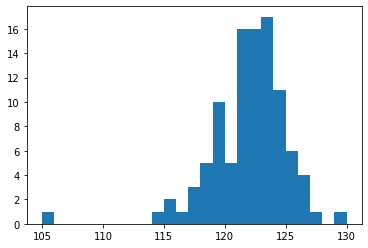

In [23]:
hdata = retdf.pred_endlap
plt.hist(hdata, bins=range(min(hdata),max(hdata)+1))

(array([50.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0., 20.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

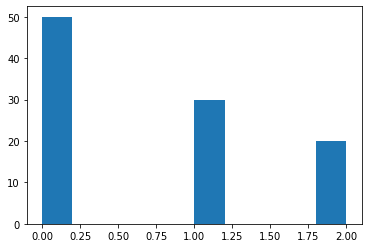

In [25]:
hdata = retdf.pred_endrank
plt.hist(hdata, bins=10)

In [39]:
a = hdata.values.astype(int).reshape((1,100))
a

array([[2, 0, 2, 2, 0, 1, 0, 1, 1, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1,
        0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 2, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2, 1, 1,
        2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0]])

In [48]:
from scipy import stats
stats.mode(hdata.values).mode[0]

0.0

In [32]:
a=np.array([1,2,3,4,0,0,0,0,0,0,0,0,0,0])
np.median(a)

0.0

In [47]:
dfall = get_alldf()
evalret = stint.get_evalret(dfall)

model: acc={0.57}, mae={3.88}, rmse={5.52},r2={-4.04}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}


### normal tuning

In [3]:
acc, ret, pret = {}, {}, {}

In [4]:
fmodestr = {stint.FEATURE_PITAGE:'pitage',stint.FEATURE_STATUS:'nopitage'}
lapstr = {0:'noinlap',1:'inlap',2:'outlap'}
for year in ['2018','2019']:
    for runts in ['TIMEDIFF','RANK']:
        for fmode in [stint.FEATURE_PITAGE, stint.FEATURE_STATUS]:
            for lapmode in [0,1,2]:
                mid = 'oracle-%s-%s-%s-%s'%(runts, year, lapstr[lapmode], fmodestr[fmode])
                acc[mid], ret[mid] = test_pitmodel('oracle', 'Indy500-%s'%year, runts, loopcnt=3,inlapmode=lapmode,featuremode = fmode)
                #if acc[mid] != []:
                #    pret[mid] = prisk(ret[mid][0][1], ret[mid][0][2])
                #else:
                #    pret[mid] = []


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.73}, mae={3.11}, rmse={4.79},r2={-0.24}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.69}, mae={3.19}, rmse={4.87},r2={-0.29}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.70}, mae={3.17}, rmse={4.84},r2={-0.19}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
[[ 0.70723104  3.15343915  4.83252122 -0.24008215]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.68}, mae={3.39}, rmse={5.10},r2={-0.29}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.67}, mae={3.40}, rmse={5.02},r2={-0.34}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.69}, mae={3.31}, rmse={4.97},r2={-0.40}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
[[ 0.67730496  3.36879433  5.02908453 -0.34263119]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.70}, mae={3.22}, rmse={4.92},r2={-0.35}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.68}, mae={3.27}, rmse={5.01},r2={-0.43}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.68}, mae={3.32}, rmse={4.99},r2={-0.37}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
[[ 0.68783069  3.26984127  4.97281091 -0.38313951]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.68}, mae={3.52}, rmse={5.37},r2={-0.33}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.68}, mae={3.54}, rmse={5.25},r2={-0.37}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.67}, mae={3.60}, rmse={5.45},r2={-0.45}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
[[ 0.67730496  3.55141844  5.35897401 -0.38543364]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={1.00}, mae={1.00}, rmse={1.41},r2={-7.00}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
model: acc={1.00}, mae={0.50}, rmse={0.71},r2={0.00}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
model: acc={1.00}, mae={1.00}, rmse={1.41},r2={-7.00}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
[[ 1.          0.83333333  1.1785113  -4.66666667]
 [ 0.          1.5         1.58113883  0.9       ]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


loading model...done!, ctx:gpu(0)
model: acc={0.69}, mae={3.39}, rmse={5.05},r2={-0.52}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.69}, mae={3.60}, rmse={5.45},r2={-0.29}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.68}, mae={3.41}, rmse={5.08},r2={-0.38}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
[[ 0.68783069  3.46737213  5.19239603 -0.39800016]
 [ 0.1005291   4.10582011  5.523399    0.56876669]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.64}, mae={3.57}, rmse={5.26},r2={-0.99}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.65}, mae={3.71}, rmse={5.34},r2={-0.86}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.67}, mae={3.60}, rmse={5.21},r2={-0.93}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
[[ 0.65602837  3.62411348  5.26876319 -0.92471326]
 [ 0.10638298  4.24468085  5.71113135  0.53004139]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.58}, mae={3.54}, rmse={5.08},r2={-3.50}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.54}, mae={3.68}, rmse={5.27},r2={-3.59}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.63}, mae={3.37}, rmse={5.03},r2={-4.21}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
[[ 0.58553792  3.5308642   5.1234845  -3.76861834]
 [ 0.1005291   4.10582011  5.523399    0.56876669]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.65}, mae={3.55}, rmse={5.21},r2={-3.40}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.64}, mae={3.38}, rmse={4.97},r2={-2.59}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.62}, mae={3.66}, rmse={5.26},r2={-3.20}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
[[ 0.63652482  3.53014184  5.14650584 -3.06341277]
 [ 0.10638298  4.24468085  5.71113135  0.53004139]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={1.00}, mae={2.50}, rmse={3.54},r2={-2.12}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
model: acc={1.00}, mae={1.50}, rmse={2.12},r2={-3.50}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
model: acc={1.00}, mae={2.00}, rmse={2.83},r2={-2.56}, 
            naive: acc={0.00}, mae={1.50}, rmse={1.58},r2={0.90}
[[ 1.          2.          2.82842712 -2.72685185]
 [ 0.          1.5         1.58113883  0.9       ]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=8

In [5]:
fmodestr = {stint.FEATURE_PITAGE:'pitage',stint.FEATURE_STATUS:'nopitage'}
lapstr = {0:'noinlap',1:'inlap',2:'outlap'}
for year in ['2018','2019']:
    for runts in ['TIMEDIFF','RANK']:
        for fmode in [stint.FEATURE_PITAGE, stint.FEATURE_STATUS]:
            for lapmode in [0,1,2]:
                mid = 'pitmodel-%s-%s-%s-%s'%(runts, year, lapstr[lapmode], fmodestr[fmode])
                acc[mid], ret[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k.pickle', 
                                    'Indy500-%s'%year, runts, loopcnt=3,inlapmode=lapmode,featuremode = fmode)
                #if acc[mid] != []:
                #    pret[mid] = prisk(ret[mid][0][1], ret[mid][0][2])
                #else:
                #    pret[mid] = []

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.55}, mae={4.01}, rmse={5.79},r2={-1.30}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.58}, mae={3.80}, rmse={5.65},r2={-0.97}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.59}, mae={3.83}, rmse={5.76},r2={-1.10}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
[[ 0.57319224  3.88007055  5.73427669 -1.12056705]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.55}, mae={4.11}, rmse={5.89},r2={-0.93}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.59}, mae={4.07}, rmse={5.70},r2={-0.87}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.57}, mae={4.11}, rmse={5.86},r2={-1.26}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
[[ 0.56914894  4.09751773  5.81495358 -1.02092739]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.54}, mae={4.01}, rmse={5.78},r2={-1.12}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.54}, mae={4.02}, rmse={5.75},r2={-1.11}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
model: acc={0.61}, mae={3.88}, rmse={5.69},r2={-1.19}, 
            naive: acc={0.10}, mae={4.10}, rmse={5.50},r2={0.57}
[[ 0.56613757  3.96825397  5.73999623 -1.14009759]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.58}, mae={4.20}, rmse={6.16},r2={-0.88}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.52}, mae={4.37}, rmse={6.28},r2={-1.15}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
model: acc={0.54}, mae={4.26}, rmse={6.38},r2={-1.07}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.69},r2={0.53}
[[ 0.54787234  4.2748227   6.271653   -1.03497465]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.63}, mae={3.56}, rmse={5.30},r2={-1.27}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.62}, mae={3.77}, rmse={5.41},r2={-1.02}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.61}, mae={3.80}, rmse={5.51},r2={-1.21}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
[[ 0.62081129  3.71075838  5.40584204 -1.16668121]
 [ 0.1005291   4.10582011  5.523399    0.56876669]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.63}, mae={3.84}, rmse={5.65},r2={-1.62}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.62}, mae={3.99}, rmse={5.84},r2={-1.58}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.61}, mae={3.87}, rmse={5.62},r2={-1.23}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
[[ 0.61879433  3.90248227  5.7014732  -1.47645742]
 [ 0.10638298  4.24468085  5.71113135  0.53004139]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.53}, mae={3.72}, rmse={5.24},r2={-3.67}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.54}, mae={3.73}, rmse={5.27},r2={-4.49}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
model: acc={0.53}, mae={3.75}, rmse={5.33},r2={-3.63}, 
            naive: acc={0.10}, mae={4.11}, rmse={5.52},r2={0.57}
[[ 0.5361552   3.7319224   5.28004124 -3.92867215]
 [ 0.1005291   4.10582011  5.523399    0.56876669]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
ERROR: key 14-45 not found in model
model: acc={0.59}, mae={3.88}, rmse={5.47},r2={-4.46}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.57}, mae={3.74}, rmse={5.38},r2={-3.00}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
model: acc={0.57}, mae={3.84}, rmse={5.45},r2={-3.42}, 
            naive: acc={0.11}, mae={4.24}, rmse={5.71},r2={0.53}
[[ 0.57446809  3.82092199  5.43238235 -3.62655648]
 [ 0.10638298  4.24468085  5.71113135  0.53004139]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2


INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p0.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p2.pickle with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4
a short ts: carid=88，len=4


In [6]:
acc

{'oracle-TIMEDIFF-2018-noinlap-pitage': array([[[ 0.73015873,  3.10582011,  4.78810254, -0.24021232],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68783069,  3.18518519,  4.87407568, -0.2891362 ],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.7037037 ,  3.16931217,  4.83538544, -0.19089792],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]]]),
 'oracle-TIMEDIFF-2018-inlap-pitage': array([[[ 0.67553191,  3.39361702,  5.09693274, -0.29255276],
         [ 0.10638298,  4.2393617 ,  5.69107177,  0.53333692]],
 
        [[ 0.67021277,  3.39893617,  5.01752249, -0.34025196],
         [ 0.10638298,  4.2393617 ,  5.69107177,  0.53333692]],
 
        [[ 0.68617021,  3.31382979,  4.97279835, -0.39508884],
         [ 0.10638298,  4.2393617 ,  5.69107177,  0.53333692]]]),
 'oracle-TIMEDIFF-2018-outlap-pitage': [],
 'oracle-TIMEDIFF-2018-noinlap-nopitage': array([[[ 0.6984127 ,  3.21693122,  4.92268263, -0.34985685],
   

In [22]:
acc

{'oracle-TIMEDIFF-2018-noinlap-nopitage': array([[[ 0.69312169,  3.24867725,  4.94520237, -0.3905952 ],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68783069,  3.24867725,  4.81070235, -0.35874678],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68253968,  3.20634921,  4.86429601, -0.34142966],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68783069,  3.25396825,  4.95855842, -0.3439144 ],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.69312169,  3.26455026,  4.85830985, -0.39702378],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.66666667,  3.28042328,  4.87841591, -0.33637984],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68253968,  3.23280423,  4.93609961, -0.42489833],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.66137566,  3.28571429,  4.93609961, -0.3930

In [1]:
print(np.mean(acc['oracle-TIMEDIFF-2018-inlap-nopitage'], axis=0))
print(np.mean(acc['oracle-TIMEDIFF-2019-inlap-nopitage'], axis=0))

NameError: name 'np' is not defined

In [ ]:
print(np.mean(acc['pitmodel-TIMEDIFF-2018-inlap-nopitage'], axis=0))
print(np.mean(acc['pitmodel-TIMEDIFF-2019-inlap-nopitage'], axis=0))

In [ ]:
df1 =ret['oracle-RANK-2019-noinlap-nopitage'][0]
df2 =ret['pitmodel-RANK-2019-noinlap-nopitage'][0]
print('2019: oracle:%d, pitmodel:%d'%(len(df1),len(df2)))

In [20]:
def get_best(pitmodel=True, verbose=False):
    best_acc = {2018:[0, ''], 2019:[0,'']}
    best_mae = {2018:[100, ''], 2019:[100,'']}
    for model in ret.keys():
        if model.find('pitmodel')==0:
            if len(ret[model]) > 0:
                oracle = model.replace('pitmodel','oracle')
                if verbose:
                    print('model:',(oracle))
                acc_oracle = np.mean(acc[oracle], axis=0)
                if verbose:
                    print(acc_oracle)

                if verbose:
                    print('model:',(model))
                acc_model = np.mean(acc[model], axis=0)
                if verbose:
                    print(acc_model)

                if model.find('2018') > 0:
                    year = 2018
                else:
                    year = 2019
                    
                if pitmodel:
                    test_model = acc_model
                    modelname = model
                else:
                    test_model = acc_oracle
                    modelname = oracle
                    
                #mae
                if test_model[0, 0] > best_acc[year][0]:
                    best_acc[year][0] = test_model[0, 0]
                    best_acc[year][1] = modelname

                if test_model[0, 1] < best_mae[year][0]:
                    best_mae[year][0] = test_model[0, 1]
                    best_mae[year][1] = modelname
                
    #print('mae',best_mae)
    #print('acc',best_acc)                
    return best_acc, best_mae
                


In [21]:
get_best(pitmodel=True, verbose=False)

({2018: [0.5687301587301588, 'pitmodel-TIMEDIFF-2018-noinlap-nopitage'],
  2019: [0.533581395348837, 'pitmodel-TIMEDIFF-2019-noinlap-nopitage']},
 {2018: [3.9983068783068774, 'pitmodel-TIMEDIFF-2018-noinlap-nopitage'],
  2019: [4.5127906976744185, 'pitmodel-TIMEDIFF-2019-noinlap-nopitage']})

In [23]:
get_best(pitmodel=False, verbose=False)

({2018: [0.6846560846560846, 'oracle-TIMEDIFF-2018-noinlap-nopitage'],
  2019: [0.6297674418604651, 'oracle-TIMEDIFF-2019-noinlap-nopitage']},
 {2018: [3.248148148148149, 'oracle-TIMEDIFF-2018-noinlap-nopitage'],
  2019: [3.61953488372093, 'oracle-TIMEDIFF-2019-noinlap-nopitage']})

In [20]:
get_best(pitmodel=True, verbose=False)

({2018: [0.6208112874779541, 'pitmodel-RANK-2018-noinlap-pitage'],
  2019: [0.5162790697674419, 'pitmodel-TIMEDIFF-2019-noinlap-nopitage']},
 {2018: [3.710758377425044, 'pitmodel-RANK-2018-noinlap-pitage'],
  2019: [4.0060060060060065, 'pitmodel-RANK-2019-inlap-nopitage']})

In [21]:
get_best(pitmodel=False, verbose=False)

({2018: [0.7072310405643739, 'oracle-TIMEDIFF-2018-noinlap-pitage'],
  2019: [0.627906976744186, 'oracle-TIMEDIFF-2019-noinlap-nopitage']},
 {2018: [3.1534391534391535, 'oracle-TIMEDIFF-2018-noinlap-pitage'],
  2019: [3.578294573643411, 'oracle-TIMEDIFF-2019-noinlap-nopitage']})

In [8]:
best_acc = {2018:[0, ''], 2019:[0,'']}
best_mae = {2018:[100, ''], 2019:[100,'']}
for model in ret.keys():
    if model.find('pitmodel')==0:
        if len(ret[model]) > 0:
            oracle = model.replace('pitmodel','oracle')
            print('model:',(oracle))
            acc_oracle = np.mean(acc[oracle], axis=0)
            print(acc_oracle)
            
            print('model:',(model))
            acc_model = np.mean(acc[model], axis=0)
            print(acc_model)
            
            if model.find('2018') > 0:
                year = 2018
            else:
                year = 2019
            
            #mae
            if acc_model[0, 0] > best_acc[year][0]:
                best_acc[year][0] = acc_model[0, 0]
                best_acc[year][1] = model
                
            if acc_model[0, 1] < best_mae[year][0]:
                best_mae[year][0] = acc_model[0, 1]
                best_mae[year][1] = model
                
                
print('mae',best_mae)
print('acc',best_acc)

model: oracle-TIMEDIFF-2018-noinlap-pitage
[[ 0.70723104  3.15343915  4.83252122 -0.24008215]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]
model: pitmodel-TIMEDIFF-2018-noinlap-pitage
[[ 0.57319224  3.88007055  5.73427669 -1.12056705]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]
model: oracle-TIMEDIFF-2018-inlap-pitage
[[ 0.67730496  3.36879433  5.02908453 -0.34263119]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]
model: pitmodel-TIMEDIFF-2018-inlap-pitage
[[ 0.56914894  4.09751773  5.81495358 -1.02092739]
 [ 0.10638298  4.2393617   5.69107177  0.53333692]]
model: oracle-TIMEDIFF-2018-noinlap-nopitage
[[ 0.68783069  3.26984127  4.97281091 -0.38313951]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]
model: pitmodel-TIMEDIFF-2018-noinlap-nopitage
[[ 0.56613757  3.96825397  5.73999623 -1.14009759]
 [ 0.1005291   4.1005291   5.50276506  0.57198262]]
model: oracle-TIMEDIFF-2018-inlap-nopitage
[[ 0.67730496  3.55141844  5.35897401 -0.38543364]
 [ 0.10638298  4.2393617

### test

In [ ]:
tacc, tret = {}, {}

In [ ]:
mid = 'oracle-2018'
tacc[mid], tret[mid] = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1)


In [ ]:
mid = 'ranknet-2018-debug'
tacc[mid], tret[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 
                                   'Indy500-2018', 'TIMEDIFF', loopcnt=1,
                                    inlapmode=1,featuremode =stint.FEATURE_STATUS )


In [ ]:
allpits, pitmat, maxlap = stint.get_pitlaps(verbose=True)
#print(len(allpits), maxlap)
nextpit, maxnext = stint.get_nextpit(pitmat, 30)

print(nextpit, maxnext)

In [ ]:
len(pitmat)

In [ ]:
pitmat

In [23]:
df=ret['pitmodel-RANK-2018-noinlap-pitage'][0]
df

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,13,28,20.0,12.0,-8.0,-1,14.0,-6.0,-1
1,14,29,10.0,1.0,-9.0,-1,7.0,-3.0,-1
2,59,29,32.0,22.0,-10.0,-1,28.0,-4.0,-1
3,3,30,10.0,4.0,-6.0,-1,7.0,-3.0,-1
4,20,30,7.0,0.0,-7.0,-1,0.0,-7.0,-1
...,...,...,...,...,...,...,...,...,...
184,25,195,16.0,14.0,-2.0,-1,13.0,-3.0,-1
185,59,195,21.0,21.0,0.0,0,21.0,0.0,0
186,60,195,17.0,15.0,-2.0,-1,15.0,-2.0,-1
187,19,196,15.0,18.0,3.0,1,17.0,2.0,1


In [24]:
df=ret['oracle-TIMEDIFF-2019-inlap-pitage'][0]
df

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,10,7,31.0,12.0,-19.0,-1,30.0,-1.0,-1
1,24,7,30.0,23.0,-7.0,-1,31.0,1.0,1
2,98,7,27.0,29.0,2.0,1,31.0,4.0,1
3,22,31,15.0,5.0,-10.0,-1,2.0,-13.0,-1
4,2,33,27.0,18.0,-9.0,-1,14.0,-13.0,-1
...,...,...,...,...,...,...,...,...,...
217,3,184,21.0,17.0,-4.0,-1,21.0,0.0,0
218,24,184,17.0,18.0,1.0,1,19.0,2.0,1
219,48,184,20.0,19.0,-1.0,-1,20.0,0.0,0
220,60,184,18.0,20.0,2.0,1,17.0,-1.0,-1


In [25]:

df=ret['oracle-RANK-2019-noinlap-nopitage'][0]
df

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
0,10,7,31.0,12.0,-19.0,-1,31.0,0.0,0
1,24,7,30.0,23.0,-7.0,-1,30.0,0.0,0
2,98,7,27.0,29.0,2.0,1,27.0,0.0,0
3,22,31,15.0,5.0,-10.0,-1,0.0,-15.0,-1
4,2,33,27.0,18.0,-9.0,-1,12.0,-15.0,-1
...,...,...,...,...,...,...,...,...,...
210,3,184,21.0,17.0,-4.0,-1,21.0,0.0,0
211,24,184,17.0,18.0,1.0,1,16.0,-1.0,-1
212,48,184,20.0,19.0,-1.0,-1,20.0,0.0,0
213,60,184,18.0,20.0,2.0,1,18.0,0.0,0


In [28]:
np.mean(acc['oracle-TIMEDIFF-2019-noinlap-pitage'],axis=0)

array([[ 0.61085271,  3.87751938,  5.71170474, -0.13350819],
       [ 0.15813953,  4.25581395,  6.45809389,  0.430447  ]])

In [29]:
np.mean(acc['pitmodel-RANK-2018-noinlap-pitage'],axis=0)

array([[ 0.62081129,  3.71075838,  5.40584204, -1.16668121],
       [ 0.1005291 ,  4.10582011,  5.523399  ,  0.56876669]])

In [33]:
np.mean(acc['pitmodel-TIMEDIFF-2019-noinlap-nopitage'],axis=0)

array([[ 0.51627907,  4.5875969 ,  6.50518216, -0.87430609],
       [ 0.15813953,  4.25581395,  6.45809389,  0.430447  ]])

In [37]:
np.mean(acc['pitmodel-RANK-2019-noinlap-pitage'],axis=0)

array([[ 0.49302326,  4.42325581,  6.37255417, -0.89674152],
       [ 0.15813953,  4.25581395,  6.45809389,  0.430447  ]])

In [36]:
np.mean(acc['pitmodel-RANK-2019-inlap-nopitage'],axis=0)

array([[ 0.45795796,  4.00600601,  6.0306237 , -1.94041352],
       [ 0.18018018,  4.03603604,  6.25292724,  0.46046139]])

In [ ]:
correct = df[df['sign']==df['pred_sign']] 
acc = len(correct)/len(df)
acc

In [ ]:
stint.get_evalret(df)

In [ ]:
ret ={ }
ret['oracle'] = df
ret['curtrack'] = stint.run_simulation(predictor, 2, stint.freq, datamode=stint.MODE_TESTCURTRACK )

In [ ]:
stint.get_evalret(ret['curtrack'])

In [ ]:
ret['zerotrack'] = stint.run_simulation(predictor, 2, stint.freq, datamode=stint.MODE_TESTZERO )

In [ ]:
stint.get_evalret(ret['zerotrack'])

### test sim by pred

In [ ]:
def simulation2(datasetid, testevent, taskid, runts, expid, predictionlen, datamode, loopcnt, featuremode = stint.FEATURE_STATUS):
    #
    # configurataion
    #
    # model path:  <_dataset_id>/<_task_id>-<trainid>/
    #_dataset_id = 'indy2013-2018-nocarid'
    stint.init()
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._train_len = 40
    predictor = stint.load_model(predictionlen, 'oracle',trainid='2018')

    ret2 = {}
    for i in range(loopcnt):
        ret2[i] = stint.run_simulation_pred(predictor, predictionlen, stint.freq, datamode=datamode)

    acc = []
    for i in ret2.keys():
        df = ret2[i]
        _x = stint.get_evalret(df)
        acc.append(_x)

    b = np.array(acc)
    print(np.mean(b, axis=0))
    
    return b

In [ ]:
accret = simulation('indy2013-2018-nocarid', 'Indy500-2018', 
                    'rank',stint.COL_RANK,'rank',
                   2, stint.MODE_ORACLE_LAPONLY, 3)

In [ ]:
accret = simulation('indy2013-2018-nocarid', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,3)


In [ ]:
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

In [ ]:
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE,5)
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_TESTCURTRACK,5)
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_TESTZERO,5)

In [ ]:
accret = simulation('indy2013-2018-pitage-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5, featuremode = stint.FEATURE_PITAGE)

In [ ]:
accret = simulation('indy2013-2018', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

In [ ]:
accret = simulation('indy2013-2018', 'Indy500-2019', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

In [ ]:
### pitmodel -- top8
accret = simulation('indy2013-2018', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)
accret = simulation('indy2013-2018', 'Indy500-2019', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

In [ ]:
### pitmodel -- top8
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2018', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)
accret = simulation('indy2013-2018-nocarid-context40', 'Indy500-2019', 
                    'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                   2, stint.MODE_ORACLE_LAPONLY,5)

### sim pred

In [ ]:
#
# configurataion
#
# model path:  <_dataset_id>/<_task_id>-<trainid>/
#_dataset_id = 'indy2013-2018-nocarid'
stint.init()

#stint._dataset_id = 'indy2013-2018'
stint._test_event = 'Indy500-2018'
#_test_event = 'Indy500-2019'

#stint._dataset_id = 'indy2013-2018-nocarid-context40'
#stint._feature_mode = stint.FEATURE_STATUS
stint._dataset_id = 'indy2013-2018-pitage-nocarid-context40'
stint._feature_mode = stint.FEATURE_PITAGE

stint._context_ratio = 0.

stint._task_id = 'timediff'  # rank,laptime, the trained model's task
stint._run_ts = stint.COL_TIMEDIFF   #COL_LAPTIME,COL_RANK
stint._exp_id='timediff2rank'  #rank, laptime, laptim2rank, timediff2rank... 

stint._train_len = 40
predictor = stint.load_model(2, 'oracle',trainid='2018')
df2 = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE_LAPONLY)
stint.get_evalret(df2)
df3 = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)
stint.get_evalret(df3)

In [ ]:
df2[df2['carno']==12]

In [ ]:
df2

In [ ]:
stint.get_evalret(df2)

In [ ]:
ret2 = {}
for i in range(10):
    ret2[i] = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE_LAPONLY)
    
acc = []
for i in ret2.keys():
    df = ret2[i]
    _x = stint.get_evalret(df)
    acc.append(_x)

b = np.array(acc)
np.mean(b, axis=0)

In [ ]:
df = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)

In [ ]:
df[df['carno']==12]

In [ ]:
stint.get_evalret(df)

In [ ]:
acc = []
for i in ret.keys():
    df = ret[i]
    _x = stint.get_evalret(df)
    acc.append(_x)

b = np.array(acc)
np.mean(b, axis=0)

In [ ]:
a = [(1,2,3),(2,3,4)]
np.array(a)

In [ ]:
len(ret)

In [ ]:
#
# configurataion
#
# model path:  <_dataset_id>/<_task_id>-<trainid>/
#_dataset_id = 'indy2013-2018-nocarid'
stint.init()
stint._dataset_id = 'indy2013-2018-nocarid-context40'
stint._test_event = 'Indy500-2019'
#_test_event = 'Indy500-2019'

stint._feature_mode = stint.FEATURE_STATUS
stint._context_ratio = 0.

stint._task_id = 'timediff'  # rank,laptime, the trained model's task
stint._run_ts = stint.COL_TIMEDIFF   #COL_LAPTIME,COL_RANK
stint._exp_id='timediff2rank'  #rank, laptime, laptim2rank, timediff2rank... 

stint._train_len = 40
predictor = stint.load_model(2, 'oracle',trainid='2018')

In [ ]:
df = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)

In [ ]:
stint.get_evalret(df)

In [ ]:
ret2 = {}
for i in range(10):
    ret2[i] = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)

In [ ]:
acc = []
for i in ret2.keys():
    df = ret2[i]
    _x = stint.get_evalret(df)
    acc.append(_x)

b = np.array(acc)
np.mean(b, axis=0)

### debug

In [ ]:
#
# configurataion
#
# model path:  <_dataset_id>/<_task_id>-<trainid>/
#_dataset_id = 'indy2013-2018-nocarid'
stint.init()
stint._dataset_id = 'indy2013-2018-nocarid-context40'
stint._test_event = 'Indy500-2019'
#_test_event = 'Indy500-2019'

stint._feature_mode = stint.FEATURE_STATUS
stint._context_ratio = 0.

stint._task_id = 'timediff'  # rank,laptime, the trained model's task
stint._run_ts = stint.COL_TIMEDIFF   #COL_LAPTIME,COL_RANK
stint._exp_id='timediff2rank'  #rank, laptime, laptim2rank, timediff2rank... 

stint._train_len = 40
predictor = stint.load_model(2, 'oracle',trainid='2018')

In [ ]:
df = stint.run_simulation_pred(predictor, 2, stint.freq, datamode=stint.MODE_ORACLE)

In [ ]:
stint.get_evalret(df)

### difference ? oracle .vs. pred

In [ ]:
#df, df2
df

In [ ]:
df2

In [ ]:
oracle = df[['carno','startlap']].values
pred =  df2[['carno','startlap']].values

In [ ]:
a = set(['%s-%s'%(x[0],x[1]) for x in oracle])
b = set(['%s-%s'%(x[0],x[1]) for x in  pred])
a -b

In [ ]:
df[df['carno']==3]

In [ ]:
df2[df2['carno']==3]

In [ ]:
_, data2018, _ = stint.load_data('Indy500-2018')
data2018[data2018['completed_laps']==200]

In [ ]:
topK = data2018[data2018['completed_laps']==200]['car_number'].values
topK

In [ ]:
topK_df = df[df['carno'].isin(topK[:5])]
stint.get_evalret(topK_df)

In [ ]:
len(topK_df)

In [ ]:
topK_df2 = df2[df2['carno'].isin(topK[:5])]
stint.get_evalret(topK_df2)

In [ ]:
len(topK_df2)

### check the dataset

In [ ]:
df = ret['oracle-2018']

In [ ]:
df = df[0]
df[df['carno']==6]

In [ ]:
len(df)

In [ ]:
dftemp = df[['carno','startlap', 'startrank','endrank']].sort_values(['carno','startlap'])
test = dftemp[['carno','startlap', 'startrank','endrank']].values.astype(int)
dfout = pd.DataFrame(test, columns =['carno','startlap', 'startrank','endrank'])
dfout.to_csv('test_db_ranknet2.csv')

In [ ]:
df = ret['ranknet-2018'][0]
df[df['carno']==6]

In [ ]:
len(df)

In [ ]:
ret['ranknet-timediff-2019']

In [ ]:
ret.keys()

In [ ]:
df=ret['oracle-2018'][0]
df.to_csv('result-stint')

In [ ]:
df = ret['oracle-TIMEDIFF-2018-noinlap-pitage'][0]
df[df['carno']==12]

In [ ]:
df

In [ ]:
df[df['carno']==12]

In [ ]:
df = ret['oracle-TIMEDIFF-2018-inlap-pitage'][0]
df[df['carno']==12]

In [ ]:
df = ret['pitmodel-TIMEDIFF-2018-outlap-nopitage'][0]
df[df['carno']==12]

In [ ]:
stint._inlap_status = 0

stint.init('oracle')

In [ ]:
accx, retx = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1)
df_oracle_2018 = retx[0]

In [ ]:
stint.get_evalret(df_oracle_2018)

In [ ]:
accx2, retx2 = test_pitmodel('oracle', 'Indy500-2019', 'TIMEDIFF', loopcnt=1)
df_oracle_2019 = retx2[0]

In [ ]:
def neweval(df_refer, mid):
    dfml = df_refer
    dfranknet = ret[mid][0]
    carlist = set(list(dfml['carno'].values))
    dfpits = []
    for car in carlist:
        pitlaps = dfml[dfml['carno']==car].startlap
        dfpits.append(dfranknet[(dfranknet['carno']==car) & (dfranknet['startlap'].isin(pitlaps))])

    df_ranknet = pd.concat(dfpits)
    accret = stint.get_evalret(df_ranknet)
    
    return df_ranknet, accret


def neweval2(df_refer, df2):
    dfml = df_refer
    dfranknet = df2
    carlist = set(list(dfml['carno'].values))
    dfpits = []
    for car in carlist:
        pitlaps = dfml[dfml['carno']==car].startlap
        dfpits.append(dfranknet[(dfranknet['carno']==car) & (dfranknet['startlap'].isin(pitlaps))])

    df_ranknet = pd.concat(dfpits)
    accret = stint.get_evalret(df_ranknet)
    
    return df_ranknet, accret

In [ ]:
dfn, accn = {} ,{}

In [ ]:
mid = 'oracle-TIMEDIFF-2018-inlap-pitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'pitmodel-TIMEDIFF-2018-inlap-pitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'pitmodel-RANK-2018-inlap-pitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'pitmodel-RANK-2018-inlap-nopitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'pitmodel-TIMEDIFF-2018-inlap-nopitage'
dfn[mid], accn[mid] = neweval(df_oracle_2018,mid)

In [ ]:
mid = 'oracle-TIMEDIFF-2018-inlap-pitage'
dfn[mid][dfn[mid]['carno']==12]

In [ ]:
df_oracle_2018[df_oracle_2018['carno']==12]

In [ ]:
acc2, ret2 = {},{}

In [ ]:
#stint.FEATURE_PITAGE, stint.FEATURE_STATUS
mid = 'oracle-timediff-2018-inlap-nopitage'
acc2[mid], ret2[mid] = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1,
                                     inlapmode=1,featuremode = stint.FEATURE_STATUS)

In [ ]:
#stint.FEATURE_PITAGE, stint.FEATURE_STATUS
mid = 'pitmodel-rank-2018-inlap-nopitage'
acc2[mid], ret2[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2018', 'RANK', loopcnt=1,
                                     inlapmode=1,featuremode = stint.FEATURE_STATUS)

In [ ]:
#stint.FEATURE_PITAGE, stint.FEATURE_STATUS
mid = 'pitmodel-rank-2018-noinlap-nopitage'
acc2[mid], ret2[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2018', 'RANK', loopcnt=1,
                                     inlapmode=0,featuremode = stint.FEATURE_STATUS)

In [ ]:
#stint.FEATURE_PITAGE, stint.FEATURE_STATUS
mid = 'pitmodel-rank-2018-noinlap-pitage'
acc2[mid], ret2[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2018', 'RANK', loopcnt=1,
                                     inlapmode=0,featuremode = stint.FEATURE_PITAGE)

In [ ]:
df= ret2[mid][0]
df[df['carno']==59]

In [ ]:
df

In [ ]:
neweval2(df, df_oracle_2018)

In [ ]:
neweval2(df_oracle_2018,ret2[mid][0])

In [ ]:
neweval2(df_oracle_2018,df_oracle_2018)

In [ ]:
df_oracle_2018[140:]

In [38]:
### investigate the blackhorse car 27
df = ret['oracle-TIMEDIFF-2018-noinlap-pitage'][0]
df[df['carno']==27]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
26,27,33,19.0,21.0,2.0,1,21.0,2.0,1
50,27,49,21.0,21.0,0.0,0,13.0,-8.0,-1
93,27,94,21.0,17.0,-4.0,-1,20.0,-1.0,-1
126,27,129,17.0,8.0,-9.0,-1,9.0,-8.0,-1
167,27,173,8.0,3.0,-5.0,-1,3.0,-5.0,-1


In [52]:
df = ret['oracle-TIMEDIFF-2018-noinlap-pitage'][0]
df[df['carno']==12]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
11,12,31,3.0,5.0,2.0,1,2.0,-1.0,-1
39,12,49,5.0,0.0,-5.0,-1,3.0,-2.0,-1
89,12,93,0.0,1.0,1.0,1,1.0,1.0,1
121,12,128,1.0,7.0,6.0,1,1.0,0.0,0
160,12,170,7.0,0.0,-7.0,-1,0.0,-7.0,-1


In [53]:
top10 = [12, 20, 9, 27, 28, 22, 29, 1, 6]
car27 = df[df['carno'].isin(top10)]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=4.23, mae=3.02, r2=0.11


(3.020408163265306, 4.233009254294015, 0.11437276133229024)

In [55]:
#top10 = [12, 20, 9, 27, 28, 22, 29, 1, 6]
top10 = [12, 20, 9, 27, 28]
car27 = df[df['carno'].isin(top10)]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=3.47, mae=2.52, r2=0.31


(2.52, 3.4698703145794942, 0.30963302752293576)

In [56]:
df = ret['pitmodel-TIMEDIFF-2018-noinlap-pitage'][0]
df[df['carno']==27]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
26,27,33,19.0,21.0,2.0,1,26.0,7.0,1
50,27,49,21.0,21.0,0.0,0,17.0,-4.0,-1
93,27,94,21.0,17.0,-4.0,-1,21.0,0.0,0
126,27,129,17.0,8.0,-9.0,-1,16.0,-1.0,-1
167,27,173,8.0,3.0,-5.0,-1,3.0,-5.0,-1


In [47]:
car27 = df[df['carno']==27]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=4.92, mae=4.20, r2=-0.36


(4.2, 4.919349550499537, -0.3565022421524666)

In [48]:
car27 = df[df['carno']==12]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=3.85, mae=3.20, r2=-3.30


(3.2, 3.847076812334269, -3.3023255813953494)

In [49]:
car27 = df
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=5.79, mae=4.01, r2=-1.30


(4.01058201058201, 5.790888665342439, -1.297248783182022)

In [50]:
len(df)

189

In [58]:
top10 = [12, 20, 9, 27, 28, 22, 29, 1, 6]
car27 = df[df['carno'].isin(top10)]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=6.07, mae=4.37, r2=-1.14


(4.36734693877551, 6.074369035848371, -1.139696647666892)

In [57]:
#top10 = [12, 20, 9, 27, 28, 22, 29, 1, 6]
top10 = [12, 20, 9, 27, 28]
car27 = df[df['carno'].isin(top10)]
evaluate(car27['pred_diff'].values,car27['diff'].values)

rmse=5.35, mae=3.72, r2=-0.62


(3.72, 5.347896782848375, -0.6226397966594044)

In [46]:
import math
from sklearn import metrics
def evaluate(test_y, pred_y):
    mae = metrics.mean_absolute_error(test_y, pred_y) 
    rmse = math.sqrt(metrics.mean_squared_error(test_y, pred_y))
    r2 = metrics.r2_score(test_y, pred_y)
    print('rmse=%.2f, mae=%.2f, r2=%.2f'%(rmse, mae, r2))
    return mae,rmse, r2

In [14]:
acc

INFO:root:Using GPU


{'oracle-TIMEDIFF-2018-noinlap-nopitage': array([[[ 0.69312169,  3.24867725,  4.94520237, -0.3905952 ],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68783069,  3.24867725,  4.81070235, -0.35874678],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68253968,  3.20634921,  4.86429601, -0.34142966],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68783069,  3.25396825,  4.95855842, -0.3439144 ],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.69312169,  3.26455026,  4.85830985, -0.39702378],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.66666667,  3.28042328,  4.87841591, -0.33637984],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.68253968,  3.23280423,  4.93609961, -0.42489833],
         [ 0.1005291 ,  4.1005291 ,  5.50276506,  0.57198262]],
 
        [[ 0.66137566,  3.28571429,  4.93609961, -0.3930